# Classification

In this notebook we will see how to perform classification using Python and Scikit-Learn.

Keep in mind that doing classification is not so easy. There are many things to consider, such as the **type of data**, the **type of problem**, the **type of algorithm**, the type of **evaluation**, etc. Here we will cover the basic aspects of classification, but you should always consider the specificities of your problem. 

To give you an idea, here are some questions you should ask yourself before doing classification:

- What is the type of data? Is it numerical, categorical, text, images, etc.? This will affect the kind of algorithm you can use and how you will preprocess the data or tune the **model hyperparameters**.
- What is the type of problem? Is it binary classification, multiclass classification, multilabel classification, etc.? This will affect the kind of algorithm you can use and how you will **evaluate** the model.
- Also when dealing with multi-class classification you have to make sure that classes are **balanced**. If not, you will have to use stratified sampling to make sure that the training set is representative of the overall population or use other techniques to deal with imbalanced classes. Using accuracy when classes are imbalanced is not a good idea. You should switch to a metric that can **handle imbalanced classes**, such as precision, recall, F1 score, ROC AUC, etc.

We will focus on **binary classification** by using a GridSearch approach and then compare the two models with ROC AUC score. We will also see how to deal with imbalanced classes but we will not go into details about **overfitting** and **underfitting** or how to tune hyperparameters properly; we will just let GridSearchCV do the job for us.

## Setup

First, we import the libraries we will use in this notebook.

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.inspection import permutation_importance

import dtreeviz

Then we will use the `load_breast_cancer` aka **[UCI ML Breast Cancer Wisconsin (Diagnostic) dataset](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)** function to load the dataset. We can easly convert the dataset to a Pandas DataFrame by calling the `as_frame` parameter in sklearn.

In [14]:
data = load_breast_cancer(as_frame=True) # load data in pandas format
df = data.frame
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Now we need to check if classes are balanced. We can do this by using the `value_counts` method on the target column.

In [121]:
df['target'].value_counts()

target
1    357
0    212
Name: count, dtype: int64

<Axes: title={'center': 'Target distribution'}, ylabel='Frequency'>

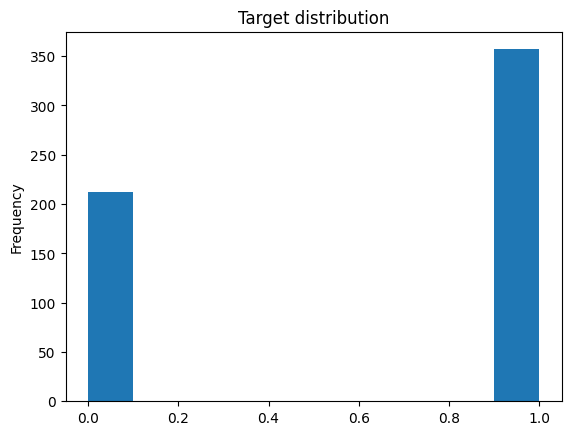

In [120]:
df['target'].plot(kind='hist', title='Target distribution')

As we can see they are not perfectly balanced, but they are not too imbalanced either. We can proceed with the classification but maybe we will not use accuracy as a metric and we will use a metric that can handle imbalanced classes, such as precision, recall, F1 score, ROC AUC, etc.

---

> **Note:** Why we are not using accuracy?

## The Limitations of Accuracy for Imbalanced Classes

When dealing with imbalanced classes, where the number of samples in different classes is significantly unequal, accuracy may not provide a reliable evaluation of a classification model's performance. Let's consider a binary classification problem with two classes: the majority class (label 0) and the minority class (label 1).

### Accuracy Calculation

Accuracy is calculated as the ratio of correctly classified samples to the total number of samples:


$$\text{{Accuracy}} = \frac{{\text{{Number of correctly classified samples}}}}{{\text{{Total number of samples}}}}
$$

However, accuracy alone fails to account for the nuances of imbalanced classes and can be misleading. Let's consider an extreme example:

### Example: Imbalanced Classes

Suppose we have an imbalanced dataset with 990 samples of the majority class (label 0) and only 10 samples of the minority class (label 1). We train a classifier that predicts all samples as the majority class.

#### Calculation:

- True positives (TP) = 0 (no minority class samples correctly classified)
- False positives (FP) = 0 (no minority class samples incorrectly classified as majority class)
- True negatives (TN) = 990 (all majority class samples correctly classified)
- False negatives (FN) = 10 (all minority class samples incorrectly classified as majority class)

#### Accuracy:

$$
\text{{Accuracy}} = \frac{{\text{{TP}} + \text{{TN}}}}{{\text{{TP}} + \text{{FP}} + \text{{TN}} + \text{{FN}}}} = \frac{{0 + 990}}{{0 + 0 + 990 + 10}} = 0.99
$$

In this case, the accuracy is 0.99, which may give a false impression of a highly accurate model. However, the classifier fails to correctly predict any minority class samples, which is a critical aspect of the classification problem.

### Alternative Evaluation Metrics

To address the limitations of accuracy in imbalanced classes, alternative evaluation metrics should be considered. Some commonly used metrics include precision, recall (sensitivity), specificity, F1-score, and area under the receiver operating characteristic curve (AUC-ROC). These metrics provide a more nuanced understanding of the model's performance, particularly concerning the minority class, and are better suited for imbalanced datasets.

By using appropriate evaluation metrics, we can gain a more comprehensive and accurate assessment of the classification model's performance in the context of imbalanced classes.

---

As always we will drop the target variable from the training set and we will store it in a separate variable.

Finally, we will split the dataset into a training set and a test set.

In [31]:
X = df.drop('target', axis=1)
y = df['target']
X.shape, y.shape

((569, 30), (569,))

Here we will use a split of 70% for the training set and 30% for the test set. We will also set the `random_state` parameter to 1 to make sure that we get the same split every time we run the code.

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

Define the model and fit it on the training set.

Here we can make some improvements. For example, we can use cross-validation to get a better estimate of the model performance. We can also use grid search to find the best hyperparameters for the model.

We will use grid-search to find the best hyperparameters for the model. We will use the `GridSearchCV` class from Scikit-Learn. We will pass the model, the hyperparameters we want to test and the metric we want to use to evaluate the model.

Since accuracy may be misleading when dealing with imbalanced classes, we will use the ROC-AUC score as a metric.

---

## Recall

Recall, also known as sensitivity or true positive rate, measures the ability of a classifier to correctly identify positive samples from all the actual positive samples in the dataset. It is calculated as:

$$
\text{{Recall}} = \frac{{\text{{True Positives (TP)}}}}{{\text{{True Positives (TP)}} + \text{{False Negatives (FN)}}}}
$$

Recall focuses on the ability of the classifier to minimize false negatives, which is crucial in situations where **identifying positive samples is of high importance**.

## Precision

Precision measures the proportion of correctly identified positive samples out of all samples predicted as positive by the classifier. It is calculated as:

$$
\text{{Precision}} = \frac{{\text{{True Positives (TP)}}}}{{\text{{True Positives (TP)}} + \text{{False Positives (FP)}}}}
$$

Precision focuses on minimizing false positives and is particularly **useful when the cost of false positives is high, such as in medical diagnostics or fraud detection**.

## F1-Score

The F1-score is a harmonic mean of precision and recall. It provides a balanced measure of the classifier's performance by considering both precision and recall. It is calculated as:

$$
\text{{F1-Score}} = 2 \times \frac{{\text{{Precision}} \times \text{{Recall}}}}{{\text{{Precision}} + \text{{Recall}}}}
$$

The F1-score gives equal importance to precision and recall and is particularly useful when we need to find a balance between the two metrics.

## Receiver Operating Characteristic (ROC) Curve

The Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of a binary classifier. It illustrates the trade-off between the true positive rate (TPR, also known as sensitivity or recall) and the false positive rate (FPR).

$$
\text{{ROC curve}}: \text{{TPR (True Positive Rate)}} \; \text{{vs.}} \; \text{{FPR (False Positive Rate)}}
$$

The ROC curve is created by plotting the true positive rate on the y-axis against the false positive rate on the x-axis for different classification thresholds. It shows how well the classifier separates the positive and negative classes as the threshold for classifying a sample is varied.

## Area Under the ROC Curve (AUC)

The Area Under the ROC Curve (AUC) is a scalar value that represents the overall performance of a binary classifier based on its ROC curve. It measures the probability that a randomly chosen positive sample is ranked higher than a randomly chosen negative sample.

The AUC ranges from 0 to 1, where an AUC of 0.5 indicates a random classifier, and an AUC of 1 represents a perfect classifier.

---

In [164]:
clf = DecisionTreeClassifier()

Now we will define a grid of hyperparameters to test. We will use the `GridSearchCV` class from Scikit-Learn. We will pass the model, the hyperparameters we want to test and the metric we want to use to evaluate the model.

In [169]:
param_grid = {
    'max_depth': list(np.arange(3, 10)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced'],
    'splitter': ['best', 'random'],
}

As we said we will use the ROC-AUC score as a metric and Decision Tree as a model.

In [163]:
grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc', n_jobs=-1)

We will fit the model on the training set and get the best hyperparameters along with the best fitted model.

In [143]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 10],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='roc_auc')

In [144]:
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [148]:
best_estimator

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=10)

Now we can make predictions on the test set and evaluate the model.

In [149]:
y_pred = best_estimator.predict(X_test)

We will plot the roc curve and see how the model performs. Then we will use another model and compare both models under the same metric.

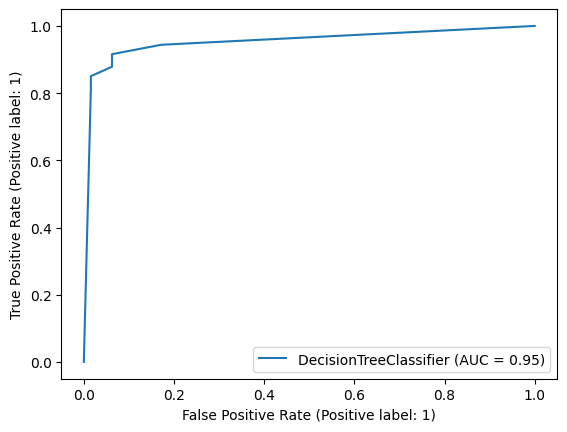

In [160]:
# plot the roc_auc curve
clf_disp = RocCurveDisplay.from_estimator(best_estimator, X_test, y_test)

> **Note:** We can also use the `dtreeviz` library to visualize the decision tree model. It will show the pattern that the model has learned from the data for classification.

An example of how to use the `dtreeviz` library is shown below

In [161]:
viz_model = dtreeviz.model(best_estimator,
                           X_train=X_train, y_train=y_train,
                           feature_names=list(df.columns),
                           target_name='Malignant/Benign', class_names=['Benign', 'Malignant'])

c:\Users\Matte\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


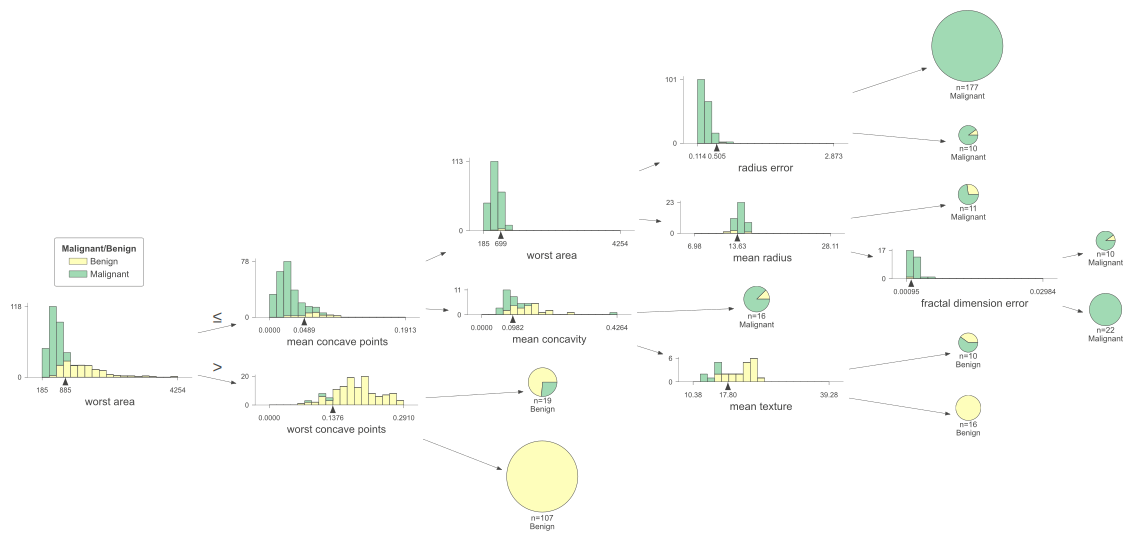

In [162]:
viz_model.view(scale=1.2, orientation="LR")

Now let's build a RandomForestClassifier and see how it performs by comparing it with the Decision Tree model.

In [171]:
clf = RandomForestClassifier()

Same step as before, we will define a grid of hyperparameters to test.

In [181]:
param_grid = {
    'n_estimators': [10],
    'max_depth': list(np.arange(3, 10)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 10],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced'],
}

In [182]:
grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc', n_jobs=-1)

In [183]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10]},
             scoring='roc_auc')

In [184]:
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [185]:
best_estimator

RandomForestClassifier(max_depth=8, n_estimators=10)

In [186]:
y_pred = best_estimator.predict(X_test)

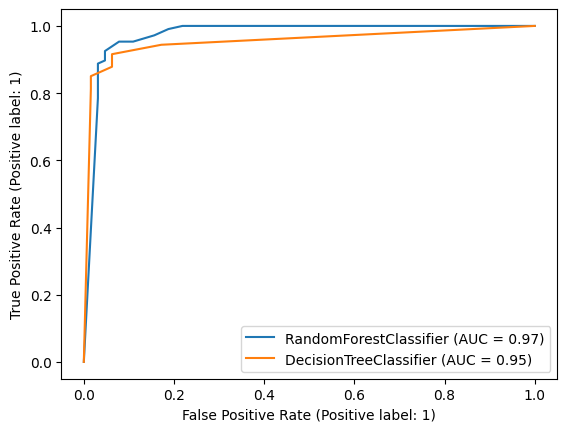

In [188]:
# plot the roc_auc curve
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(best_estimator, X_test, y_test, ax=ax)
clf_disp.plot(ax=ax)

As we can see both the models perform well, but the RandomForestClassifier performs slightly better than the Decision Tree model. Also take note that the RandomForestClassifier is more complex than the Decision Tree model. This means that the Decision Tree model is simpler and easier to interpret than the RandomForestClassifier.

Unfortunately, we cannot visualize the RandomForestClassifier model as we did with the Decision Tree model. This is because the RandomForestClassifier is an ensemble model and it is composed of many Decision Tree models. We can only measure the feature importance of the RandomForestClassifier model which is actually the average of the feature importance of all the Decision Tree models.

In [195]:
%%time

result = permutation_importance(best_estimator, X_test, y_test, n_repeats=10, random_state=1, n_jobs=-1)

CPU times: total: 125 ms
Wall time: 5.6 s


In [198]:
forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

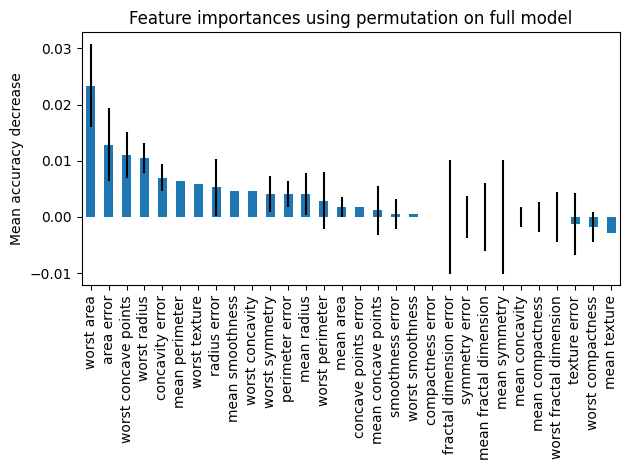

In [216]:
fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

As we can see `worst_area` is the most important feature for the RandomForestClassifier model. This means that the RandomForestClassifier model relies heavily on the `worst_area` feature to make predictions. This is not surprising since we saw that the Decision Tree model also relies heavily on the `worst_area` feature to make predictions as its first split is on the `worst_area` feature.

---

# What's Next?

Next notebook: [Clustering](https://github.com/vrughetti/python4DS/blob/main/notebooks/clustering/clustering.ipynb)